### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population by county](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa population by city](https://data.iowa.gov/Community-Demographics/Iowa-Population-by-City-ACS-5-Year-Estimates-/26ad-icvy/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)
- [iowa fuel sales](https://data.iowa.gov/Sales-Distribution/Iowa-Motor-Fuel-Sales-by-County-and-Year/hbwp-wys3/about_data)
- [iowa excessive drinking](https://www.countyhealthrankings.org/health-data/community-conditions/health-infrastructure/health-promotion-and-harm-reduction/excessive-drinking?state=19&tab=1&year=2025)

### Packages

In [2]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata
import re

# 1. Google Cloud

## 1-1. Big Query

In [3]:
SERVICE_ACCOUNT_FILE = '.streamlit/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    store_location,
    item_description,
    category_name,
    bottle_volume_ml,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date>='2024-01-01' AND date<'2025-01-01' AND state_bottle_cost>0 AND state_bottle_retail>0
AND bottles_sold>0 AND sale_dollars>0
"""

df_google_cloud = pandas_gbq.read_gbq(sql, credentials=credentials)

c:\repos\Applying-Machine-Learning\.venv\lib\site-packages\google\cloud\bigquery\table.py:2230: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.


## 1-2. Create CSV File

In [50]:
df_google = df_google_cloud.copy()
df_google['longitude'] = df_google['store_location'].str.extract(r'POINT\(([-\d\.]+) [-\d\.]+\)').astype(float)
df_google['latitude'] = df_google['store_location'].str.extract(r'POINT\([-\d\.]+ ([-\d\.]+)\)').astype(float)
df_google['gross_profit'] = (
    (df_google['state_bottle_retail'] - df_google['state_bottle_cost']) * df_google['bottles_sold']
)
df_google.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
    'category_name': 'liquor_type',
    'bottles_sold': 'bottles',
    
}, inplace=True)
df_google.columns = df_google.columns.str.lower()
df_google['store'] = df_google['store'].str.lower()
df_google['city'] = df_google['city'].str.lower()
df_google['county'] = df_google['county'].str.lower()
df_google['item'] = df_google['item'].str.lower()
df_google['liquor_type'] = df_google['liquor_type'].str.lower()
df_google['liter'] = df_google['bottle_volume_ml'] * 0.001
df_google['price_per_liter'] = df_google['state_bottle_retail'] / (df_google['liter'])
df_google = df_google[['date', 'store', 'city', 'county', 'longitude', 'latitude', 'item', 'liquor_type', 'liter', 'price_per_liter', 'state_bottle_cost', 'state_bottle_retail', 'bottles', 'sale_dollars', 'gross_profit']]
df_google.to_csv('data/google.csv', index=False)
df_google.head()

,date,store,city,county,longitude,latitude,item,liquor_type,liter,price_per_liter,state_bottle_cost,state_bottle_retail,bottles,sale_dollars,gross_profit
0,2024-09-25,hy-vee drugstore (7042) / iowa city,iowa city,johnson,-91.502100,41.666080,crown royal regal apple mini,canadian whiskies,0.05,172.8,5.76,8.64,1,8.64,2.88
1,2024-01-17,wever junction inc / wever,wever,lee,-91.227293,40.716945,crown royal mini,canadian whiskies,0.05,298.6,9.95,14.93,1,14.93,4.98
2,2024-03-01,casey's general store #32 / madrid,madrid,boone,-93.815178,41.877630,black velvet mini,canadian whiskies,0.05,266.2,8.87,13.31,1,13.31,4.44
3,2024-06-04,kum & go #137 / tiffin,tiffin,johnson,-91.665763,41.696606,black velvet mini,canadian whiskies,0.05,266.2,8.87,13.31,1,13.31,4.44
4,2024-07-24,hy-vee food store #2 (1285) / iowa city,iowa city,johnson,-91.500902,41.651412,black velvet mini,canadian whiskies,0.05,266.2,8.87,13.31,1,13.31,4.44


In [ ]:
print("The earliest date:", df_google['date'].min())
print("The latest date:", df_google['date'].max())
print("# of stores:", df_google['store'].nunique())
print("# of cities:", df_google['city'].nunique())
print("# of counties:", df_google['county'].nunique())
print("# of items:", df_google['item'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2150
# of cities: 471
# of counties: 99
# of items: 4515


# 2. Liquor Store

In [51]:
df_store = pd.read_csv('data/google.csv')
df_store = (
    df_store
    .groupby(['store', 'city', 'county', 'longitude', 'latitude', 'date', 'item', 'liquor_type'])
    .agg({
        'price_per_liter': 'mean',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store.to_csv('data/store.csv', index=False)
df_store.head()

,store,city,county,longitude,latitude,date,item,liquor_type,price_per_liter,liter,bottles,gross_profit
0,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin chocolate whiskey caramel turtle mini,whiskey liqueur,300.000000,0.05,1,5.0
1,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin chocolate whiskey mini,whiskey liqueur,300.000000,0.05,1,5.0
2,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin peanut butter chocolate whiskey mini,whiskey liqueur,300.000000,0.05,1,5.0
3,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,bookers bourbon,temporary & specialty packages,100.000000,0.75,1,25.0
4,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,crown royal regal apple,canadian whiskies,29.137143,1.75,6,102.0


In [67]:
df_store['liquor_type'].nunique()

44

# 3. City

## 3-1. Population

In [52]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city = df_pop_city[['city', 'pop_city']]
df_pop_city

,city,pop_city
0,ackley,1699
1,ackworth,106
2,adair,828
3,adel,6090
4,afton,1105
...,...,...
936,yale,316
937,yetter,16
938,yorktown,35
939,zearing,655


## 3-2. Item-Level Gross Profit

In [53]:
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_profit_city = (
    df_store
    .groupby(['city', 'month'])
    .agg(
        {
        'bottles': 'sum',
        'gross_profit': 'sum'
        }
        )
    .reset_index()
)
df_profit_city

,city,month,bottles,gross_profit
0,ackley,1,653,2130.60
1,ackley,2,481,1891.82
2,ackley,3,654,2620.66
3,ackley,4,895,3089.54
4,ackley,5,1150,3562.12
...,...,...,...,...
5389,zwingle,8,348,695.30
5390,zwingle,9,428,1720.01
5391,zwingle,10,323,1482.51
5392,zwingle,11,324,1409.26


## 3-3. City Data Frame

In [54]:
df_city = pd.merge(df_pop_city, df_profit_city, on="city", how="left")
df_city.to_csv('data/city.csv', index=False)
df_city.head()

,city,pop_city,month,bottles,gross_profit
0,ackley,1699,1.0,653.0,2130.60
1,ackley,1699,2.0,481.0,1891.82
2,ackley,1699,3.0,654.0,2620.66
3,ackley,1699,4.0,895.0,3089.54
4,ackley,1699,5.0,1150.0,3562.12


# 4. County

## 4-1. Gross Profit by Liquor Type

In [55]:
df_liquor = (
    df_google
    .groupby(['county', 'liquor_type'])
    .agg({
        'price_per_liter': 'mean',
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_liquor.head()

,county,liquor_type,price_per_liter,bottles,gross_profit
0,adair,100% agave tequila,77.00483,672,6316.35
1,adair,aged dark rum,24.0,23,136.0
2,adair,american brandies,16.70344,471,1483.18
3,adair,american cordials & liqueurs,721.278621,497,2021.76
4,adair,american distilled spirits specialty,22.304848,87,483.2


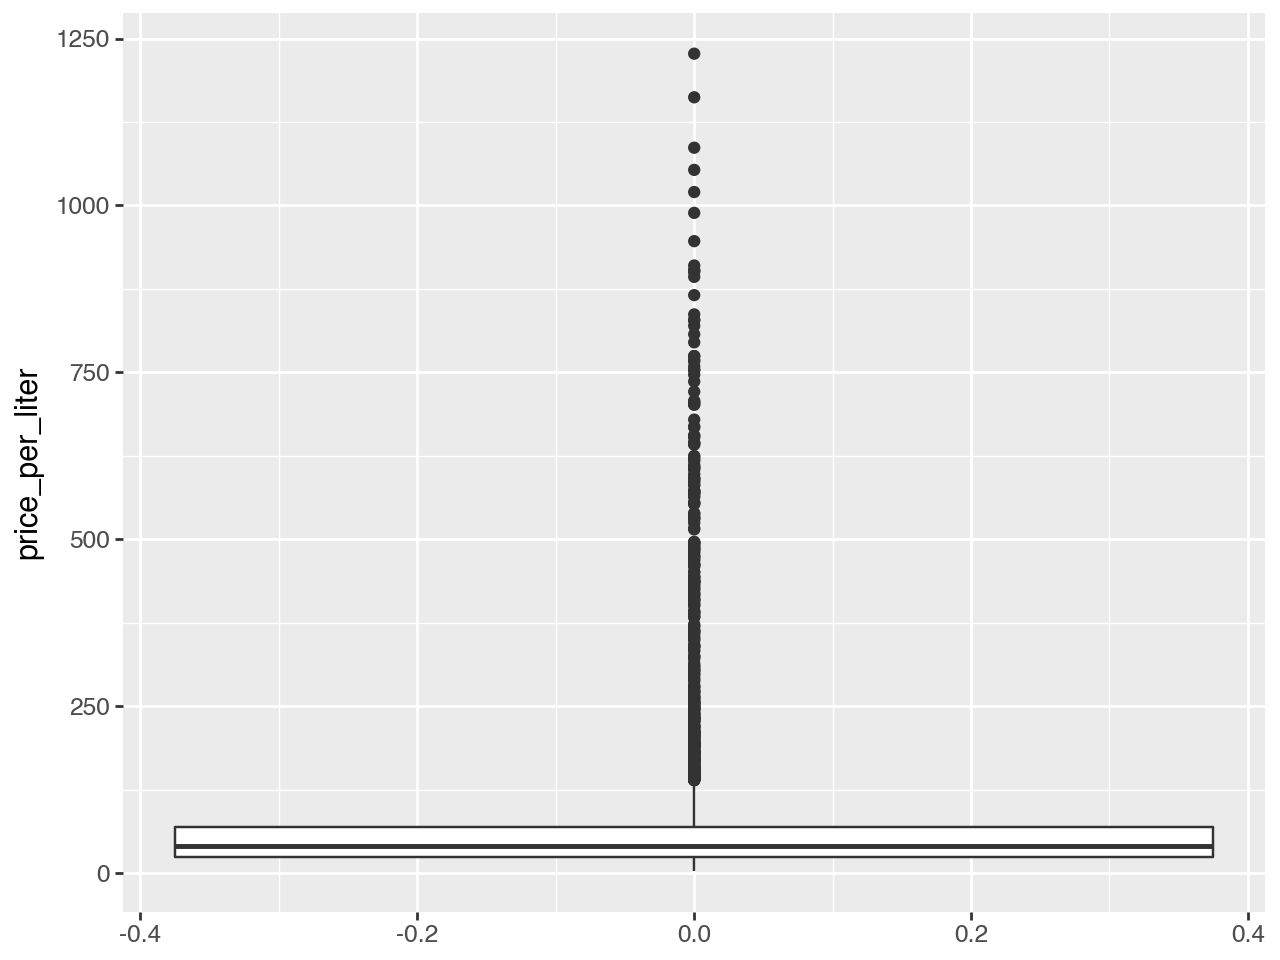

In [ ]:
p9.ggplot(df_liquor, p9.aes(y="price_per_liter"))+ p9.geom_boxplot()


In [ ]:
df_liquor['price_per_liter'].describe()

count         4221.0
mean       72.585334
std       114.017344
min         3.283333
25%             24.0
50%        40.502061
75%        70.030476
max      1227.344691
Name: price_per_liter, dtype: Float64

In [56]:
def categorize_liquor_by_price(row):
    if row['price_per_liter'] <= 24:
        return 'cheap'
    elif row['price_per_liter'] <= 70:
        return 'medium'
    else:
        return 'expensive'

df_liquor['price_range'] = df_liquor.apply(categorize_liquor_by_price, axis=1)

df_liquor = df_liquor[['county', 'liquor_type', 'price_per_liter', 'price_range', 'bottles', 'gross_profit']]
df_liquor.head()

,county,liquor_type,price_per_liter,price_range,bottles,gross_profit
0,adair,100% agave tequila,77.00483,expensive,672,6316.35
1,adair,aged dark rum,24.0,cheap,23,136.0
2,adair,american brandies,16.70344,cheap,471,1483.18
3,adair,american cordials & liqueurs,721.278621,expensive,497,2021.76
4,adair,american distilled spirits specialty,22.304848,cheap,87,483.2


## 4-2. Population

In [58]:
df_pop_county = pd.read_csv('data/population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['fips','county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']

df_geo_county = pd.read_csv('data/geo_county.csv')
df_geo_county.rename(columns={
    'Geographic Area Name (NAME)': 'county',
    'Internal Point (Latitude) (INTPTLAT)': 'latitude',
    'Internal Point (Longitude) (INTPTLON)': 'longitude'
}, inplace=True)
df_geo_county.columns = df_geo_county.columns.str.lower()
df_geo_county['county'] = df_geo_county['county'].str[:-13]
df_geo_county['county'] = df_geo_county['county'].str.lower()
df_geo_county = df_geo_county[['county','latitude', 'longitude']]
df_pop_county = pd.merge(df_pop_county, df_geo_county, on='county', how='left')
df_pop_county = df_pop_county[['fips', 'county', 'pop_county']]
df_pop_county.to_csv('data/pop_county.csv', index=False)
df_pop_county.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/geo_county.csv'

In [ ]:
df_gen_age_pop = pd.read_csv('data/gen_age_pop.csv')
df_gen_age_pop.rename(columns={
    "County": "county",
    "Female - 18 to 24 years": "female_18_24",
    "Female - 25 to 34 years": "female_25_34",
    "Female - 35 to 44 years": "female_35_44",
    "Female - 45 to 64 years": "female_45_64",
    "Female - 65 years and over": "female_65_over",
    "Male - 18 to 24 years": "male_18_24",
    "Male - 25 to 34 years": "male_25_34",
    "Male - 35 to 44 years": "male_35_44",
    "Male - 45 to 64 years": "male_45_64",
    "Male - 65 years and over": "male_65_over"
}, inplace=True)

rename_dict = {
    'black': 'black hawk',
    'buena': 'buena vista',
    'cerro': 'cerro gordo',
    'des': 'des moines',
    'palo': 'palo alto',
    'van': 'van buren',
}
df_gen_age_pop['county'] = df_gen_age_pop['county'].replace(rename_dict)
df_pop = pd.merge(df_pop_county, df_gen_age_pop, on="county", how="left")
df_pop.head()

,fips,county,pop_county,female_18_24,female_25_34,female_35_44,female_45_64,female_65_over,male_18_24,male_25_34,male_35_44,male_45_64,male_65_over
0,19157,poweshiek,18453,1286,938,978,2312,2132,1468,868,968,2237,1727
1,19101,jefferson,15440,521,946,840,1798,2090,648,1317,1093,2039,1900
2,19037,chickasaw,11658,436,544,601,1475,1397,509,594,703,1692,1206
3,19131,mitchell,10518,397,508,563,1332,1230,412,584,630,1378,1015
4,19197,wright,12656,427,587,859,1463,1537,444,805,645,1592,1350


## 4-3. Income

In [4]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income = df_income[['county', 'annual_income']]
df_income.head()

,county,annual_income
51,adair,67668
103,adams,67657
155,allamakee,55015
207,appanoose,47779
259,audubon,69105


In [47]:
#Loading and cleaning data

# 1) Load the local ACS 5-Year Income Bracket data
df_acs = (
    pd.read_csv('ACS_5Y_2023.csv', skiprows=1, skipfooter=1, engine='python')
      .drop(columns=["Geography", "Estimate!!Total:"])
      .rename(columns={"Geographic Area Name": "county"})
      .assign(
          county=lambda d: (
              d["county"]
                .str.lower()
                .str.replace(r" county.*", "", regex=True)
                .str.strip()
          )
      )
      # …and any other drops/renames you need…
)

df_acs = df_acs.loc[:, ~df_acs.columns.str.contains("Margin of Error!!", regex=False)]

df_acs.columns = (
    df_acs.columns
      # strip off everything through "Total:!!"
      .str.replace(r'^.*Total:!!', '', regex=True)
      # lowercase
      .str.lower()
      # drop $ and ,
      .str.replace(r'[\$,]', '', regex=True)
      # replace any run of whitespace with underscore
      .str.replace(r'\s+', '_', regex=True)
)

# dropping unnamed_36
df_acs = df_acs.iloc[:, :-1]

df_income_brackets = df_acs


# 2) (Optional) Preview the first few rows
print(df_income_brackets)


        county  less_than_10000  10000_to_14999  15000_to_19999  \
0        adair              100             191             134   
1        adams               71              75              89   
2    allamakee              195             151             270   
3    appanoose              303             400             228   
4      audubon              142              41             144   
..         ...              ...             ...             ...   
94   winnebago              193             182             241   
95  winneshiek              269             245             259   
96    woodbury             2067            1587            1735   
97       worth               67             103             102   
98      wright              190              97             274   

    20000_to_24999  25000_to_29999  30000_to_34999  35000_to_39999  \
0              124             122             165              95   
1               56              28              56     

## 4-4. Fuel Sales

In [48]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("hbwp-wys3",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_fuel = pd.DataFrame.from_records(df_list)
df_fuel.rename(columns={
    'calendar_year': 'year',
    # 'number_of_retail_locations': 'locations',
    'non_ethanol_gas_sales': 'gas_sales',
}, inplace=True)
df_fuel = df_fuel[df_fuel['year']=='2024']
df_fuel['county'] = df_fuel['county'].str.lower()
df_fuel = df_fuel[['county', 'gas_sales']]
df_fuel.head()

,county,gas_sales
1174,adair,895851
1175,adams,188155
1176,allamakee,923224
1177,appanoose,792131
1178,audubon,226034


## 4-5. Excessive Drinking

In [ ]:
df_drinking = pd.read_csv('data/excessive_drinking.csv')
df_drinking.columns = df_drinking.columns.str.lower()
df_drinking.rename(columns={
    'county value**': 'excessive_drinking',
}, inplace=True)
df_drinking['county'] = df_drinking['county'].str.lower()
df_drinking['excessive_drinking'] = df_drinking['excessive_drinking'].str[:2]
df_drinking = df_drinking[['county', 'excessive_drinking']]
df_drinking.head()

,county,excessive_drinking
0,iowa,25
1,adair,24
2,adams,25
3,allamakee,23
4,appanoose,23


## 4-6. County Data Frame

In [49]:
df_county = pd.merge(df_liquor, df_pop, on='county', how='left')
df_county = pd.merge(df_county, df_income_brackets, on='county', how='left')
df_county = pd.merge(df_county, df_fuel, on='county', how='left')
df_county = pd.merge(df_county, df_drinking, on='county', how='left')
df_county = df_county.drop_duplicates()
df_county['gas_sales'] = df_county['gas_sales'].astype(int)
df_county['excessive_drinking'] = df_county['excessive_drinking'].astype(int)
df_county.to_csv('data/county.csv', index=False)
df_county

NameError: name 'df_liquor' is not defined

## 4-7. County Data Frame with Months

In [10]:
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_county_with_month = (
    df_store
    .groupby(['county', 'month', 'liquor_type'])
    .agg({
        'price_per_liter': 'mean',
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_county_with_month.to_csv('data/county_with_month.csv', index=False)
df_county_with_month

,county,month,liquor_type,price_per_liter,bottles,gross_profit
0,adair,1,100% agave tequila,45.478333,23,171.67
1,adair,1,american brandies,11.388381,42,139.61
2,adair,1,american cordials & liqueurs,521.004444,8,38.96
3,adair,1,american distilled spirits specialty,22.194667,17,91.75
4,adair,1,american flavored vodka,36.181111,62,231.72
...,...,...,...,...,...,...
44718,wright,12,temporary & specialty packages,48.658519,235,2170.50
44719,wright,12,tennessee whiskies,70.166320,119,856.69
44720,wright,12,triple sec,5.715556,19,36.34
44721,wright,12,whiskey liqueur,184.954319,1376,2972.94


# 5. Data Set by Liquor Type

## 5-1. Data Set with Months

In [65]:
# categorization
df_store = pd.read_csv('data/store.csv')
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_store = (
    df_store.groupby(['store', 'month'])
    .agg({
        'longitude': 'first', 
        'latitude': 'first', 
        'city': 'first', 
        'county': 'first',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum'
    })
    .reset_index()
)

def assign_category(store_name):
    store = store_name.lower() if isinstance(store_name, str) else ""
    store_clean = store
    categories = {
        "grocery_store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor_store_bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas_station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery_brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general_store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience_store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    for category, keywords in categories.items():
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"
df_store['category'] = df_store['store'].apply(assign_category)
df_store = pd.get_dummies(df_store, columns=['category'], prefix='cat')
bool_cols = df_store.select_dtypes(include='bool').columns
df_store[bool_cols] = df_store[bool_cols].astype(int)

# merge city & county
df_city = pd.read_csv('data/city.csv')
df_city = df_city[['city', 'pop_city']]
df_county = pd.read_csv('data/county.csv')
df_county = df_county.drop(['liquor_type', 'price_per_liter','price_range', 'bottles', 'gross_profit'], axis=1)
df_county = df_county.groupby('county').first().reset_index()
df = pd.merge(df_store, df_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['gassale_x_gasstore'] = df['gas_sales'] * df_store['cat_gas_station']
df = df.drop(columns=['gas_sales'])

# widen liquor type
df_store = pd.read_csv('data/store.csv')
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_liquor_type = df_store.pivot_table(
    index=['store', 'month'],   
    columns='liquor_type',            
    values='liter',          
    aggfunc='sum',              
    fill_value=0            
)
df_liquor_type = df_liquor_type.reset_index()
def clean_column_name(col):
    col = str(col).lower()
    col = col.replace('/', '_')  
    col = col.replace('*', '')
    col = col.replace('.', '_')  
    col = col.replace(':', '')
    col = col.replace('(', '')
    col = col.replace(')', '')
    col = col.replace(',', '')
    col = re.sub(r'\s+', '_', col)  
    col = re.sub(r'_+', '_', col)  
    col = re.sub(r'[^a-z0-9_]', '_', col)   
    col = re.sub(r'_+', '_', col)          
    col = col.strip('_')       
    return 'l_' + col             
df_liquor_type.columns = [clean_column_name(col) for col in df_liquor_type.columns]
df_liquor_type.rename(columns={
    "l_store": "store",
    "l_month": "month"
}, inplace=True)

# merge 
df_with_month = pd.merge(df, df_liquor_type, on=['store', 'month'], how='inner')
df_with_month = df_with_month.drop_duplicates()
df_with_month.to_csv('data/iowa_with_month.csv', index=False)
df_with_month

,store,month,longitude,latitude,city,county,liter,bottles,gross_profit,cat_convenience_store,...,l_single_malt_scotch,l_special_order_items,l_spiced_rum,l_straight_bourbon_whiskies,l_straight_rye_whiskies,l_temporary_specialty_packages,l_tennessee_whiskies,l_triple_sec,l_whiskey_liqueur,l_white_rum
0,'da booze barn / west bend,1,-94.444878,42.959231,west bend,palo alto,112.775,593,4499.84,0,...,0.00,0.00,5.050,11.150,0.00,7.00,5.425,0.0,3.000,1.75
1,'da booze barn / west bend,2,-94.444878,42.959231,west bend,palo alto,104.100,637,4598.18,0,...,2.25,0.00,5.250,14.500,0.00,2.50,0.750,0.0,4.250,0.00
2,'da booze barn / west bend,3,-94.444878,42.959231,west bend,palo alto,113.350,672,4840.74,0,...,0.00,0.00,7.000,10.500,0.75,3.25,1.750,1.0,4.250,0.00
3,'da booze barn / west bend,4,-94.444878,42.959231,west bend,palo alto,84.150,522,3828.55,0,...,0.00,0.00,5.250,8.500,1.00,2.50,1.750,0.0,1.500,1.75
4,'da booze barn / west bend,5,-94.444878,42.959231,west bend,palo alto,114.050,664,4691.36,0,...,0.00,1.75,2.800,10.875,0.75,4.00,4.100,1.0,1.750,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23049,yesway store #1198 / swea city,7,-94.307848,43.385321,swea city,kossuth,25.900,580,1773.04,0,...,0.00,0.00,6.500,0.050,0.00,0.00,0.000,0.0,5.775,0.00
23050,yesway store #1198 / swea city,9,-94.307890,43.384960,swea city,kossuth,9.050,289,626.34,0,...,0.00,0.00,0.000,0.000,0.00,0.00,0.000,0.0,2.600,0.00
23051,yesway store #1198 / swea city,10,-94.307890,43.384960,swea city,kossuth,12.500,240,653.52,0,...,0.00,0.00,0.000,0.000,0.00,0.75,0.000,0.0,0.000,0.00
23052,yesway store #1198 / swea city,11,-94.307890,43.384960,swea city,kossuth,9.125,198,642.18,0,...,0.00,0.00,0.375,0.750,0.00,0.00,0.000,0.0,0.000,0.00


## 5-2. Data Set without Months

In [66]:
# categorization
df_store = pd.read_csv('data/store.csv')
df_store = (
    df_store.groupby(['store'])
    .agg({
        'longitude': 'first', 
        'latitude': 'first', 
        'city': 'first', 
        'county': 'first',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum'
    })
    .reset_index()
)
def assign_category(store_name):
    store = store_name.lower() if isinstance(store_name, str) else ""
    store_clean = store
    categories = {
        "grocery_store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor_store_bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas_station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery_brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general_store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience_store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    for category, keywords in categories.items():
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"
df_store['category'] = df_store['store'].apply(assign_category)
df_store = pd.get_dummies(df_store, columns=['category'], prefix='cat')
bool_cols = df_store.select_dtypes(include='bool').columns
df_store[bool_cols] = df_store[bool_cols].astype(int)

# merge city & county
df_city = pd.read_csv('data/city.csv')
df_city = df_city[['city', 'pop_city']]
df_county = pd.read_csv('data/county.csv')
df_county = df_county.drop(['liquor_type', 'price_per_liter','price_range', 'bottles', 'gross_profit'], axis=1)
df_county = df_county.groupby('county').first().reset_index()
df = pd.merge(df_store, df_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['gassale_x_gasstore'] = df['gas_sales'] * df_store['cat_gas_station']
df = df.drop(columns=['gas_sales'])

# widen liquor type
df_store = pd.read_csv('data/store.csv')
df_liquor_type = df_store.pivot_table(
    index=['store'],   
    columns='liquor_type',            
    values='liter',          
    aggfunc='sum',              
    fill_value=0            
)
df_liquor_type = df_liquor_type.reset_index()
def clean_column_name(col):
    col = str(col).lower()
    col = col.replace('/', '_')  
    col = col.replace('*', '')
    col = col.replace('.', '_')  
    col = col.replace(':', '')
    col = col.replace('(', '')
    col = col.replace(')', '')
    col = col.replace(',', '')
    col = re.sub(r'\s+', '_', col)  
    col = re.sub(r'_+', '_', col)  
    col = re.sub(r'[^a-z0-9_]', '_', col)   
    col = re.sub(r'_+', '_', col)          
    col = col.strip('_')       
    return 'l_' + col             
df_liquor_type.columns = [clean_column_name(col) for col in df_liquor_type.columns]
df_liquor_type.rename(columns={
    "l_store": "store",
    "l_month": "month"
}, inplace=True)

# merge 
df_without_month = pd.merge(df, df_liquor_type, on='store', how='left')
df_without_month = df_without_month.drop_duplicates()
df_without_month.to_csv('data/iowa_without_month.csv', index=False)
df_without_month

,store,longitude,latitude,city,county,liter,bottles,gross_profit,cat_convenience_store,cat_distillery_brewery,...,l_single_malt_scotch,l_special_order_items,l_spiced_rum,l_straight_bourbon_whiskies,l_straight_rye_whiskies,l_temporary_specialty_packages,l_tennessee_whiskies,l_triple_sec,l_whiskey_liqueur,l_white_rum
0,'da booze barn / west bend,-94.445160,42.959230,west bend,palo alto,1060.325,5570,41723.39,0,0,...,3.75,3.5,49.05,120.225,3.25,54.225,29.425,4.0,24.150,5.250
1,10th hole inn & suite / gift shop,-92.547768,43.363937,riceville,howard,15.800,183,1031.32,0,0,...,0.00,0.0,2.25,0.000,0.00,2.300,0.750,1.0,0.000,0.000
2,173 craft distillery (et),-93.382627,43.137118,clear lake,cerro gordo,51.000,1224,9583.20,0,1,...,0.00,0.0,1.50,0.750,0.00,8.250,0.000,0.0,0.000,3.000
3,1st stop beverage shop,-93.561475,41.600294,des moines,polk,1945.950,61371,201153.76,0,0,...,3.70,0.0,49.85,110.200,2.20,137.750,30.175,1.0,70.450,88.025
4,218 fuel express,-92.738542,43.122847,floyd,floyd,1604.500,15744,90997.87,0,0,...,10.50,0.0,93.35,103.500,7.50,14.250,54.450,6.0,94.750,40.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,yesway store # 10022/ waterloo,-92.314981,42.494966,waterloo,black hawk,44.600,1684,5465.30,0,0,...,0.00,0.0,2.30,1.125,0.00,0.000,1.600,0.0,8.675,0.100
2145,yesway store # 10034/ belmond,-93.617219,42.845246,belmond,wright,317.750,4897,15824.10,0,0,...,0.00,0.0,37.15,4.600,0.00,0.750,1.200,0.0,23.800,32.500
2146,yesway store # 1029/ clarion,-93.735920,42.731620,clarion,wright,194.550,2947,10221.30,0,0,...,0.00,0.0,23.30,5.500,0.00,1.750,1.375,0.0,17.900,13.925
2147,yesway store # 1036/ kanawha,-93.793665,42.934474,kanawha,hancock,115.250,2378,7712.14,0,0,...,0.00,0.0,0.75,3.000,0.00,2.250,3.900,0.0,7.725,0.000


# 6. Data Set by Item

## 6-1. Data Set by Item with month

In [3]:
# categorization
df_store = pd.read_csv('data/store.csv')
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_store = (
    df_store.groupby(['store', 'month'])
    .agg({
        'longitude': 'first', 
        'latitude': 'first', 
        'city': 'first', 
        'county': 'first',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum'
    })
    .reset_index()
)

def assign_category(store_name):
    store = store_name.lower() if isinstance(store_name, str) else ""
    store_clean = store
    categories = {
        "grocery_store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor_store_bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas_station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery_brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general_store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience_store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    for category, keywords in categories.items():
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"
df_store['category'] = df_store['store'].apply(assign_category)
df_store = pd.get_dummies(df_store, columns=['category'], prefix='cat')
bool_cols = df_store.select_dtypes(include='bool').columns
df_store[bool_cols] = df_store[bool_cols].astype(int)

# merge city & county
df_city = pd.read_csv('data/city.csv')
df_city = df_city[['city', 'pop_city']]
df_county = pd.read_csv('data/county.csv')
df_county = df_county.drop(['liquor_type', 'price_per_liter','price_range', 'bottles', 'gross_profit'], axis=1)
df_county = df_county.groupby('county').first().reset_index()
df = pd.merge(df_store, df_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['gassale_x_gasstore'] = df['gas_sales'] * df_store['cat_gas_station']
df = df.drop(columns=['gas_sales'])

# widen liquor type
df_store = pd.read_csv('data/store.csv')
df_store['month'] = pd.to_datetime(df_store['date']).dt.month
df_liquor_type = df_store.pivot_table(
    index=['store', 'month'],   
    columns='item',            
    values='liter',          
    aggfunc='sum',              
    fill_value=0            
)
df_liquor_type = df_liquor_type.reset_index()
def clean_column_name(col):
    col = str(col).lower()
    col = col.replace('/', '_')  
    col = col.replace('*', '')
    col = col.replace('.', '_')  
    col = col.replace(':', '')
    col = col.replace('(', '')
    col = col.replace(')', '')
    col = col.replace(',', '')
    col = re.sub(r'\s+', '_', col)  
    col = re.sub(r'_+', '_', col)  
    col = re.sub(r'[^a-z0-9_]', '_', col)   
    col = re.sub(r'_+', '_', col)          
    col = col.strip('_')       
    return 'l_' + col             
df_liquor_type.columns = [clean_column_name(col) for col in df_liquor_type.columns]
df_liquor_type.rename(columns={
    "l_store": "store",
    "l_month": "month"
}, inplace=True)

# merge 
df_with_month = pd.merge(df, df_liquor_type, on=['store', 'month'], how='inner')
df_with_month = df_with_month.drop_duplicates()
df_with_month.to_csv('data/iowa_with_month_item.csv', index=False)
df_with_month

,store,month,longitude,latitude,city,county,liter,bottles,gross_profit,cat_convenience_store,...,l_yu,l_yukon_jack,l_yukon_jack_fire,l_yukon_jack_perma_frost,l_zaya_gran_reserva_rum,l_zing_zang_blazing_bloody_mary_rts,l_zing_zang_bloody_mary_rts,l_zirbenz_stone_pine_liqueur_of_the_alps,l_zubrowka_bison_grass_vodka,l_zucca_rabarbaro
0,'da booze barn / west bend,1,-94.444878,42.959231,west bend,palo alto,112.775,593,4499.84,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'da booze barn / west bend,2,-94.444878,42.959231,west bend,palo alto,104.100,637,4598.18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'da booze barn / west bend,3,-94.444878,42.959231,west bend,palo alto,113.350,672,4840.74,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,'da booze barn / west bend,4,-94.444878,42.959231,west bend,palo alto,84.150,522,3828.55,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,'da booze barn / west bend,5,-94.444878,42.959231,west bend,palo alto,114.050,664,4691.36,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23049,yesway store #1198 / swea city,7,-94.307848,43.385321,swea city,kossuth,25.900,580,1773.04,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,yesway store #1198 / swea city,9,-94.307890,43.384960,swea city,kossuth,9.050,289,626.34,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23051,yesway store #1198 / swea city,10,-94.307890,43.384960,swea city,kossuth,12.500,240,653.52,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23052,yesway store #1198 / swea city,11,-94.307890,43.384960,swea city,kossuth,9.125,198,642.18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6-2. Data Set by Item without month

In [5]:
# categorization
df_store = pd.read_csv('data/store.csv')
df_store = (
    df_store.groupby(['store'])
    .agg({
        'longitude': 'first', 
        'latitude': 'first', 
        'city': 'first', 
        'county': 'first',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum'
    })
    .reset_index()
)
def assign_category(store_name):
    store = store_name.lower() if isinstance(store_name, str) else ""
    store_clean = store
    categories = {
        "grocery_store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor_store_bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas_station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery_brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general_store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience_store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    for category, keywords in categories.items():
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"
df_store['category'] = df_store['store'].apply(assign_category)
df_store = pd.get_dummies(df_store, columns=['category'], prefix='cat')
bool_cols = df_store.select_dtypes(include='bool').columns
df_store[bool_cols] = df_store[bool_cols].astype(int)

# merge city & county
df_city = pd.read_csv('data/city.csv')
df_city = df_city[['city', 'pop_city']]
df_county = pd.read_csv('data/county.csv')
df_county = df_county.drop(['liquor_type', 'price_per_liter','price_range', 'bottles', 'gross_profit'], axis=1)
df_county = df_county.groupby('county').first().reset_index()
df = pd.merge(df_store, df_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['gassale_x_gasstore'] = df['gas_sales'] * df_store['cat_gas_station']
df = df.drop(columns=['gas_sales'])

# widen liquor type
df_store = pd.read_csv('data/store.csv')
df_liquor_type = df_store.pivot_table(
    index=['store'],   
    columns='item',            
    values='liter',          
    aggfunc='sum',              
    fill_value=0            
)
df_liquor_type = df_liquor_type.reset_index()
def clean_column_name(col):
    col = str(col).lower()
    col = col.replace('/', '_')  
    col = col.replace('*', '')
    col = col.replace('.', '_')  
    col = col.replace(':', '')
    col = col.replace('(', '')
    col = col.replace(')', '')
    col = col.replace(',', '')
    col = re.sub(r'\s+', '_', col)  
    col = re.sub(r'_+', '_', col)  
    col = re.sub(r'[^a-z0-9_]', '_', col)   
    col = re.sub(r'_+', '_', col)          
    col = col.strip('_')       
    return 'l_' + col             
df_liquor_type.columns = [clean_column_name(col) for col in df_liquor_type.columns]
df_liquor_type.rename(columns={
    "l_store": "store",
    "l_month": "month"
}, inplace=True)

# merge 
df_without_month = pd.merge(df, df_liquor_type, on='store', how='left')
df_without_month = df_without_month.drop_duplicates()
df_without_month.to_csv('data/iowa_without_month_item.csv', index=False)
df_without_month

,store,longitude,latitude,city,county,liter,bottles,gross_profit,cat_convenience_store,cat_distillery_brewery,...,l_yu,l_yukon_jack,l_yukon_jack_fire,l_yukon_jack_perma_frost,l_zaya_gran_reserva_rum,l_zing_zang_blazing_bloody_mary_rts,l_zing_zang_bloody_mary_rts,l_zirbenz_stone_pine_liqueur_of_the_alps,l_zubrowka_bison_grass_vodka,l_zucca_rabarbaro
0,'da booze barn / west bend,-94.445160,42.959230,west bend,palo alto,1060.325,5570,41723.39,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10th hole inn & suite / gift shop,-92.547768,43.363937,riceville,howard,15.800,183,1031.32,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,173 craft distillery (et),-93.382627,43.137118,clear lake,cerro gordo,51.000,1224,9583.20,0,1,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1st stop beverage shop,-93.561475,41.600294,des moines,polk,1945.950,61371,201153.76,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,218 fuel express,-92.738542,43.122847,floyd,floyd,1604.500,15744,90997.87,0,0,...,0.0,11.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,yesway store # 10022/ waterloo,-92.314981,42.494966,waterloo,black hawk,44.600,1684,5465.30,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2145,yesway store # 10034/ belmond,-93.617219,42.845246,belmond,wright,317.750,4897,15824.10,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2146,yesway store # 1029/ clarion,-93.735920,42.731620,clarion,wright,194.550,2947,10221.30,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2147,yesway store # 1036/ kanawha,-93.793665,42.934474,kanawha,hancock,115.250,2378,7712.14,0,0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_without_month = pd.read_csv('data/iowa_without_month_item.csv')
df_without_month.columns = [col.replace('.1', '_1') for col in df_without_month.columns]
df_without_month.to_csv('data/iowa_without_month_item.csv', index=False)

# 7. Data Set by Store Type

In [16]:
df_store_type = pd.read_csv('data/google.csv')
df_store_type['month'] = pd.to_datetime(df_store_type['date']).dt.month
df_store_type = (
    df_store_type.groupby(['store', 'month'])
    .agg({
        'longitude': 'first', 
        'latitude': 'first', 
        'city': 'first', 
        'county': 'first',
        'liter': 'sum',
        'bottles': 'sum',
        'gross_profit': 'sum'
    })
    .reset_index()
)

def assign_category(store_name):
    store = store_name.lower() if isinstance(store_name, str) else ""
    store_clean = store
    categories = {
        "grocery_store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor_store_bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas_station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery_brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general_store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience_store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    for category, keywords in categories.items():
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"
df_store_type['category'] = df_store_type['store'].apply(assign_category)
df_store_type.to_csv('data/store_type.csv', index=False)
df_store_type

,store,month,longitude,latitude,city,county,liter,bottles,gross_profit,category
0,'da booze barn / west bend,1,-94.444878,42.959231,west bend,palo alto,112.775,593,4499.84,liquor_store_bar
1,'da booze barn / west bend,2,-94.444878,42.959231,west bend,palo alto,104.100,637,4598.18,liquor_store_bar
2,'da booze barn / west bend,3,-94.444878,42.959231,west bend,palo alto,113.350,672,4840.74,liquor_store_bar
3,'da booze barn / west bend,4,-94.444878,42.959231,west bend,palo alto,84.150,522,3828.55,liquor_store_bar
4,'da booze barn / west bend,5,-94.444878,42.959231,west bend,palo alto,114.050,664,4691.36,liquor_store_bar
...,...,...,...,...,...,...,...,...,...,...
23096,yesway store #1198 / swea city,7,-94.307848,43.385321,swea city,kossuth,25.900,580,1773.04,gas_station
23097,yesway store #1198 / swea city,9,-94.307890,43.384960,swea city,kossuth,9.050,289,626.34,gas_station
23098,yesway store #1198 / swea city,10,-94.307890,43.384960,swea city,kossuth,12.500,240,653.52,gas_station
23099,yesway store #1198 / swea city,11,-94.307890,43.384960,swea city,kossuth,9.125,198,642.18,gas_station
